# Fair Coin

Denote by $\theta$ the probability of a coin flip results in heads.

Interpretation of a "fair coin":

- **Frequentist** - $\theta$ is 0.5; but
- **Bayesian** - $\theta$ is distributed around 0.5.

The experimental approach would differ as well:

- **Frequentist** - use data to test the null hypothesis
- **Bayesian** - use data to refine prior beliefs.

In [1]:
%matplotlib inline

import math
from scipy import stats
import pandas as pd
import numpy as np

np.random.seed(seed=13)

import matplotlib.pyplot as plt

import pystan
import arviz as az

Suppose that we record the number of head ($k$) as a versus the number of flips ($n$). How could we determine whether a coin was fair?

In [2]:
# Number of flips per experiment (or sample).
n = 500

## Frequentist Approach

First let's formulate the hypotheses:

- $H_0$: The coin is fair.
- $H_1$: The coin is not fair.

A lot of Frequentist Statistics relies on the Central Limit Theorem.

### Central Limit Theorem

Let's take a short digression: why can we treat the sampled proportion with a Normal Distribution?

> The Central Limit Theorem states that the sampling distribution of the sample means approaches a Normal Distribution as the sample size gets larger, regardless of the shape of the population distribution.

The key phrase here is "as the sample size gets larger". The Central Limit Theorem assumes a large sample size!

In [3]:
# Number of experiments (or samples).
N = 10000
# Generate samples for a fair coin using Binomial Distribution.
k = stats.binom.rvs(n, 0.5, size=N)

In [4]:
# Estimates of success probability per experiment.
k / n

array([0.496, 0.554, 0.506, ..., 0.462, 0.528, 0.492])

Let's look at the distribution of those estimates.

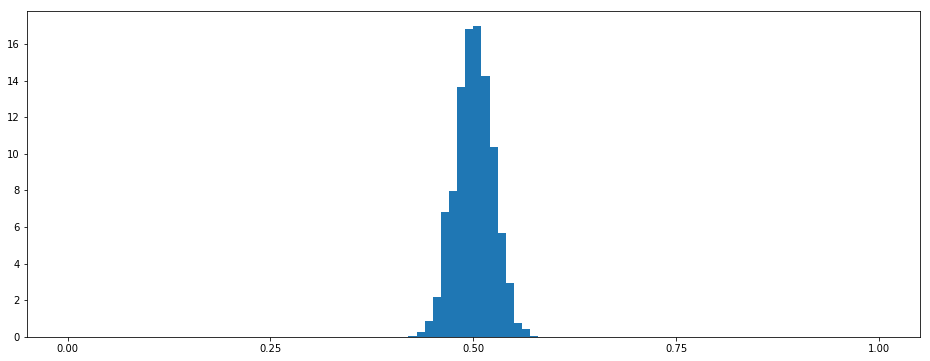

In [5]:
plt.figure(figsize=(16, 6))
plt.hist(k/n, bins=np.linspace(0, 1, 101), density=True);
plt.xticks(ticks=np.linspace(0, 1, 5));

### Hypothesis Test

Suppose that we flip a coin a number of times, recording the number of flips and the number of heads.

In [6]:
# Number of heads.
k = 230

We can think of this as a long sequence of values which are either `1` (head) or `0` (tail). What are the mean and standard error of the sequence?

In [7]:
p = k / n
p

0.46

In [8]:
sigma = math.sqrt(p * (1 - p) / n)
sigma

0.022289010745208053

What are the corresponding $z$ score and (one sided) $p$-value?

In [9]:
z = (p - 0.5) / sigma
z

-1.794606340193884

In [10]:
1 - stats.norm.cdf(abs(z))

0.03635822113987841

**Note:** For the Normal approximation to be valid, the proportion should not be too close to 0 or 1. For coin flipping this should not be a problem, but for other situations involving proportions it can be a concern.

Another (more direct) approach would be to use a binomial test.

In [11]:
stats.binom_test(k, n, p=0.5, alternative='less')

0.04051617480460322

Either approach seems significant: there is little chance that this observation could have arisen from chance alone. The Frequentist would reject the null hypothesis.

## Bayesian Approach

### Grid Approximation

What's the likelihood of k success from n trials given specific value for theta?

Strictly this should include the binomial coefficient, but since this is not a function of theta we can
safely leave it out. Normalisation will take care of it.

In [12]:
def binomial_likelihood(theta, k, n):
    return theta**k * (1 - theta)**(n - k)

Choose parameters for the $\beta$ prior. We have fairly strong reasons to believe that $\theta$ lies close to 0.5.

In [13]:
a = 100
b = 100

In [14]:
theta = np.linspace(0, 1, 500)
#
param = pd.DataFrame(data={
    'theta': theta,
    'prior': stats.beta.pdf(theta, a, b),
    'likelihood': None,
    'posterior': None
})
#
del(theta)

In [15]:
# Fix column order (by default alphabetical).
param = param[['theta', 'prior', 'likelihood', 'posterior']]

In [16]:
param['likelihood'] = [binomial_likelihood(x, k, n) for x in param['theta']]

Now invoke Bayes' Theorem to get the posterior from the likelihood and the prior.

In [17]:
param['posterior'] = param['likelihood'] * param['prior']

We still need to normalise the posterior because (1) the likelihood was not normalised and (2) we have not factored in the evidence.

In [18]:
param['posterior'] = param['posterior'] / np.trapz(param['posterior'], x=param['theta'])

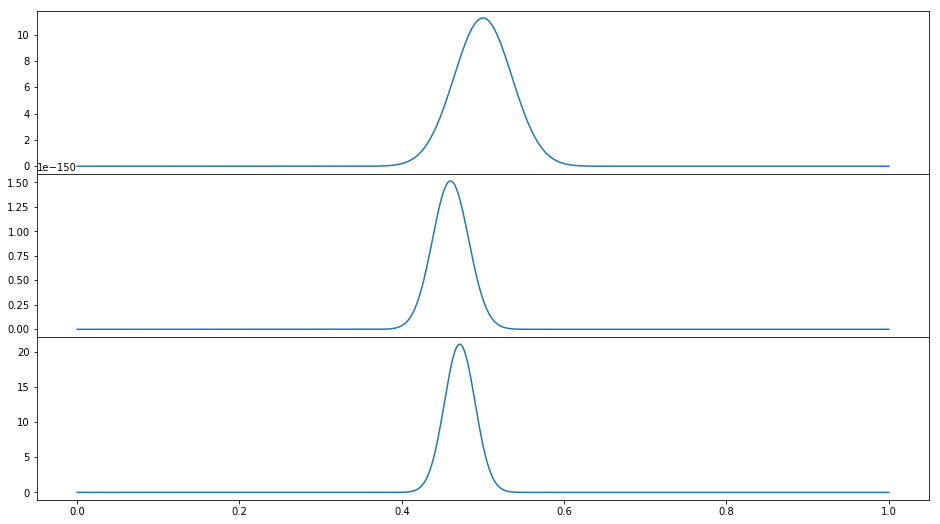

In [19]:
fig, ax = plt.subplots(nrows=3, figsize=(16,9), sharex=True)
ax[0].plot(param['theta'], param['prior'])
ax[1].plot(param['theta'], param['likelihood'])
ax[2].plot(param['theta'], param['posterior'])
fig.subplots_adjust(hspace=0)

### Using Stan: Binomial Distribution

In [20]:
stan_binomial = """
data {
  int  heads;
  int  flips;
  real a;
  real b;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  heads ~ binomial(flips, theta);      // Likelihood
  theta ~ beta(a, b);                  // Prior
}
"""

Translate the model into C++ and compile. This is a time consuming process, so avoid recompilation if the model has already been compiled.

In [21]:
try:
    model_binomial
except NameError:
    model_binomial = pystan.StanModel(model_code=stan_binomial)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d6d4a2fca5f6422c368aec7fb680f23 NOW.


The compiled model captures the original Stan code.

In [22]:
model_binomial.show()

StanModel object 'anon_model_5d6d4a2fca5f6422c368aec7fb680f23' coded as follows:

data {
  int  heads;
  int  flips;
  real a;
  real b;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  heads ~ binomial(flips, theta);      // Likelihood
  theta ~ beta(a, b);                  // Prior
}



It's also possible to take a look at the model translated into C++ (if you are that sort of masochist).

In [23]:
model_binomial.get_cppcode()

'// Code generated by Stan version 2.18.0\n\n#include <stan/model/model_header.hpp>\n\nnamespace anon_model_5d6d4a2fca5f6422c368aec7fb680f23_namespace {\n\nusing std::istream;\nusing std::string;\nusing std::stringstream;\nusing std::vector;\nusing stan::io::dump;\nusing stan::math::lgamma;\nusing stan::model::prob_grad;\nusing namespace stan::math;\n\nstatic int current_statement_begin__;\n\nstan::io::program_reader prog_reader__() {\n    stan::io::program_reader reader;\n    reader.add_event(0, 0, "start", "unknown file name");\n    reader.add_event(16, 14, "end", "unknown file name");\n    return reader;\n}\n\nclass anon_model_5d6d4a2fca5f6422c368aec7fb680f23 : public prob_grad {\nprivate:\n    int heads;\n    int flips;\n    double a;\n    double b;\npublic:\n    anon_model_5d6d4a2fca5f6422c368aec7fb680f23(stan::io::var_context& context__,\n        std::ostream* pstream__ = 0)\n        : prob_grad(0) {\n        ctor_body(context__, 0, pstream__);\n    }\n\n    anon_model_5d6d4a2fca

Set up a dictionary with the model parameters. This dictionary maps variables in Python to the corresponding variables in the Stan code.

In [24]:
coin_data = {
    'heads': k,
    'flips': n,
    'a':     a,
    'b':     b
}

Generate samples.

In [25]:
fit = model_binomial.sampling(data=coin_data)
#
# Default options:
#
# chains - 4
# iter   - 2000
# warmup - 1000

Once we have generated samples from the posterior distribution we can view summary results for each of the model parameters.

In [26]:
fit

Inference for Stan model: anon_model_5d6d4a2fca5f6422c368aec7fb680f23.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.47  5.0e-4   0.02   0.44   0.46   0.47   0.49   0.51   1446    1.0
lp__  -484.5    0.02   0.71 -486.6 -484.7 -484.2 -484.1 -484.0   1902    1.0

Samples were drawn using NUTS at Fri Oct 12 12:05:13 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

**Diagnostics**

1. `Rhat` should be close to 1.
2. `n_eff` should not be massively smaller than the number of iterations.

If either of these conditions is not satisfied then it might indicate "poor mixing" of the Markov Chains, where they have failed to successfully explore the parameter space.

There are some diagnostic functions which will indicate possible problems with the model. Ideally we want them all to return `True`.

In [27]:
pystan.diagnostics.check_div(fit)

True

In [28]:
pystan.diagnostics.check_treedepth(fit)

True

In [29]:
pystan.diagnostics.check_energy(fit)

True

Let's take a look at the distribution of the posterior.

/home/jupyter/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


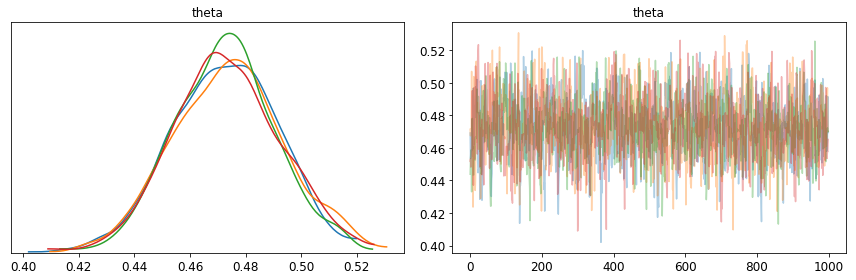

In [30]:
az.plot_trace(fit, figsize = (12, 4));

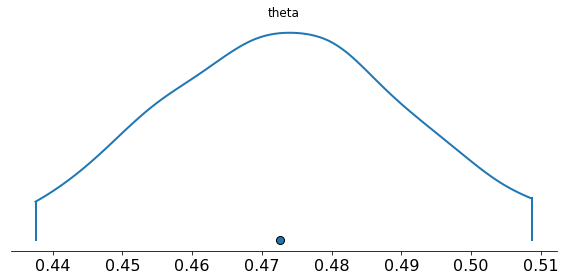

In [31]:
az.plot_density(fit, figsize = (8, 4));

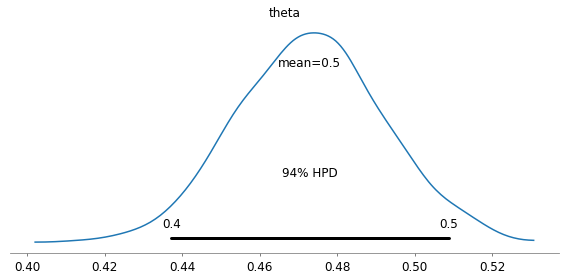

In [32]:
az.plot_posterior(fit, figsize = (8, 4));

We can access the actual samples from the posterior.

In [33]:
samples = fit.extract('theta')

theta = samples['theta']
theta

array([0.49558415, 0.44782556, 0.44889089, ..., 0.51915812, 0.4822485 ,
       0.5114579 ])

In [34]:
theta_df = fit.to_dataframe('theta')
theta_df

,chain,chain_idx,warmup,divergent__,energy__,treedepth__,accept_stat__,stepsize__,n_leapfrog__,theta
0,1,1,0,0,484.250572,1,1.000000,1.005291,3,0.469179
1,1,2,0,0,484.551081,1,0.895146,1.005291,3,0.453444
2,1,3,0,0,484.538795,2,1.000000,1.005291,3,0.456525
3,1,4,0,0,484.887676,2,0.931184,1.005291,3,0.462491
4,1,5,0,0,484.322460,1,0.961277,1.005291,1,0.458109
5,1,6,0,0,484.410080,2,0.983053,1.005291,3,0.469866
6,1,7,0,0,484.143345,1,0.983330,1.005291,3,0.478011
7,1,8,0,0,484.665610,2,0.909517,1.005291,3,0.459286
8,1,9,0,0,484.970977,2,0.929804,1.005291,3,0.496557
9,1,10,0,0,484.956869,1,1.000000,1.005291,1,0.491412


Using the samples we can evaluate characteristics of the posterior.

In [35]:
(theta > 0.5).mean()

0.074

### Using Stan: Bernoulli Distribution

Let's reformulate this as a Bernoulli problem. We need to transform the data, which are currently aggregated across all flips, into the outcomes for individual flips.

In [36]:
# Generate sequence of binary outcomes.
#
# 1 - heads
# 0 - tails
#
heads = np.repeat([1, 0], [k, n - k])
# Randomise (in place).
np.random.shuffle(heads)

In [37]:
heads

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,

Write a Stan model but now using a Bernoulli likelihood.

In [38]:
stan_bernoulli = """
data {
  int<lower=0> n;
  int<lower=0, upper=1> heads[n];
  real a;
  real b;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  heads ~ bernoulli(theta);
  theta ~ beta(a, b);
}
"""

Translate the model into C++ and compile. This is a time consuming process, so avoid recompilation if the model has already been compiled.

In [39]:
try:
    model_bernoulli
except NameError:
    model_bernoulli = pystan.StanModel(model_code=stan_bernoulli)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_edb1250bcf2bb4ef5bdb609005a79f12 NOW.


Set up a dictionary with the model parameters.

In [40]:
coin_data = {
    'n':     n,
    'heads': heads,
    'a':     a,
    'b':     b
}

Generate samples.

In [41]:
fit = model_bernoulli.sampling(data=coin_data, chains=8, warmup=500, iter=1500)

In [42]:
fit

Inference for Stan model: anon_model_edb1250bcf2bb4ef5bdb609005a79f12.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.47  3.3e-4   0.02   0.44   0.46   0.47   0.48   0.51   3175    1.0
lp__  -484.5    0.01   0.69 -486.5 -484.7 -484.2 -484.1 -484.0   2826    1.0

Samples were drawn using NUTS at Fri Oct 12 12:07:06 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

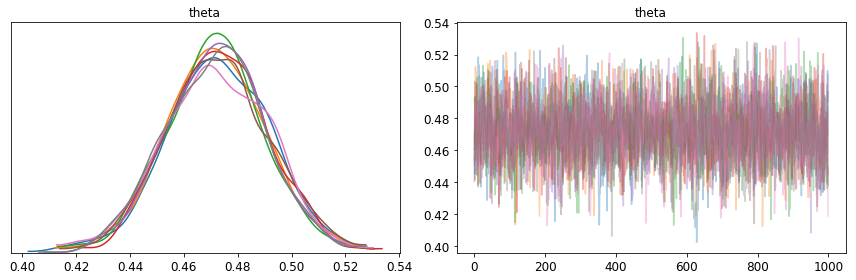

In [43]:
az.plot_trace(fit, figsize = (12, 4));

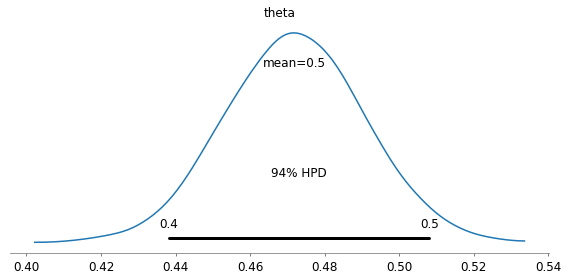

In [44]:
az.plot_posterior(fit, figsize = (8, 4));

Extract the posterior samples.

In [45]:
theta = fit.extract()['theta']

What is the probability that $\theta$ is greater than 0.5?

In [46]:
(theta > 0.5).mean()

0.06625